This document wants to train a neural network, to predict the baseline power output for a simple farm, with given wind directions.

https://github.com/stared/thinking-in-tensors-writing-in-pytorch/blob/master/5%20Nonlinear%20regression.ipynb

In [252]:
# Importing stuff
import numpy as np
from floris.tools import FlorisInterface
import matplotlib.pyplot as plt
import os
import time
from sklearn.preprocessing import StandardScaler

# Importing machine larning stuff
from sklearn.model_selection import train_test_split
import torch
import math
import torch.optim as optim
import torch.nn as nn


In [253]:
# Creating the farm:
dist = 5
nx = 3
ny = 3
turb_type = 'nrel_5MW'
combination = 'sosfs'
deflection = 'gauss'
turbulence = 'crespo_hernandez'
velocity = 'gauss'
WS_min = 4
WS_max = 20
TI_min = 0.01
TI_max = 0.15
wd_min = 270
wd_max = 360
yaw_max = 25
rho = 1.225
seed = 0

In [254]:
fi = FlorisInterface("gch.yaml")   
        
#Turns it into a dictionary and then does the changes to the model
fi_dict = fi.floris.as_dict()

fi_dict["farm"]["turbine_type"] = [turb_type]
fi_dict["wake"]["model_strings"]["combination_model"] = combination
fi_dict["wake"]["model_strings"]["deflection_model"]  = deflection
fi_dict["wake"]["model_strings"]["turbulence_model"]  = turbulence
fi_dict["wake"]["model_strings"]["velocity_model"]    = velocity
fi_dict["flow_field"]["air_density"]                  = rho

# Turns it back into a floris object:
fi = FlorisInterface(fi_dict)

D = fi.floris.farm.rotor_diameters[0]

x = np.linspace(0, D*dist*nx, nx)
y = np.linspace(0, D*dist*ny, ny)

xv, yv = np.meshgrid(x, y, indexing='xy')

layout_x =  xv.flatten()
layout_y = yv.flatten()

In [225]:
n_wind_dir = 250

In [255]:
wd = np.linspace(270, 270+45, num = n_wind_dir)

In [256]:
TI = 0.07
ws = 7
fi.reinitialize(
    layout=(layout_x, layout_y),
    wind_directions=wd,
    turbulence_intensity= TI,
    wind_speeds=[ws]
    )

In [257]:
fi.calculate_wake()

In [258]:
farm_power = fi.get_farm_power()

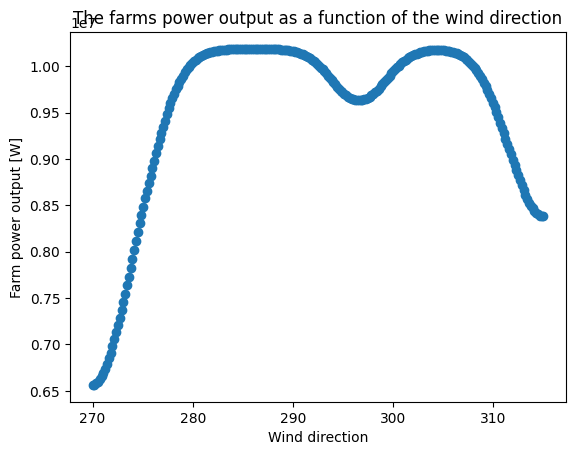

In [259]:
plt.scatter(wd, farm_power)
plt.xlabel("Wind direction")
plt.ylabel("Farm power output [W]")
plt.title("The farms power output as a function of the wind direction")
plt.show()

In [260]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [271]:
wd_data = wd.reshape(-1, 1)

In [272]:
scaler = StandardScaler()

In [273]:
scaler.fit(wd_data)

StandardScaler()

In [276]:
wd_scaled = scaler.fit_transform(wd_data)

In [279]:
myseed = 44
np.random.seed(myseed)
scaling = max(farm_power)

In [280]:
# Data Generation


lr = 2e-3
n_epochs = 45000
plot_every = n_epochs/5


device = 'cuda' if torch.cuda.is_available() else 'cpu'

#x_train_tensor = torch.from_numpy(x).float().to(device)
#y_train_tensor = torch.from_numpy(y).float().to(device)

x_train_tensor = torch.from_numpy(wd_scaled).float().to(device)
y_train_tensor = torch.from_numpy(farm_power/scaling).float().to(device)

In [285]:
torch.manual_seed(myseed)
hidden = 500
hidden2 = 500


In [286]:
model = nn.Sequential(
  nn.Linear(1, hidden),
  nn.ReLU(),
  nn.Linear(hidden, hidden2),
  nn.ReLU(),
  nn.Linear(hidden2,1),
  
).to(device)

loss_fn = nn.MSELoss(reduction='mean')
#loss_fn = nn.MSELoss(reduction='sum') is bad
#loss_fn = nn.L1Loss(reduction='mean')
#loss_fn = nn.L1Loss(reduction='sum')

optimizer = optim.SGD(model.parameters(), lr=lr)

losses = []


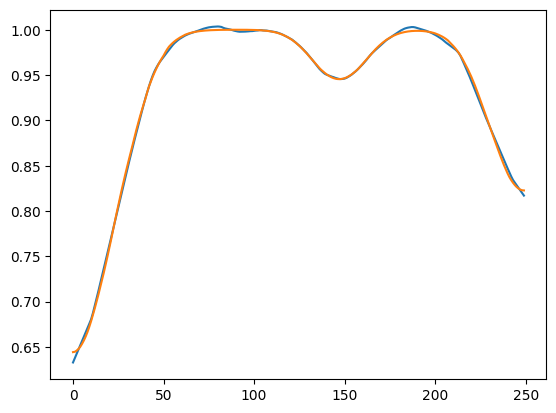

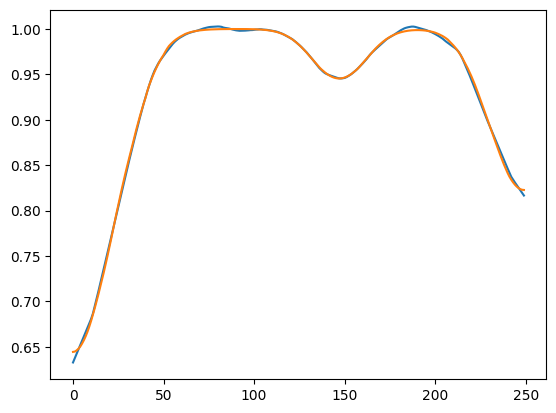

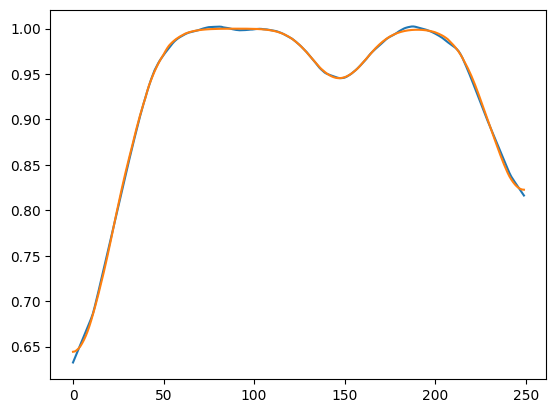

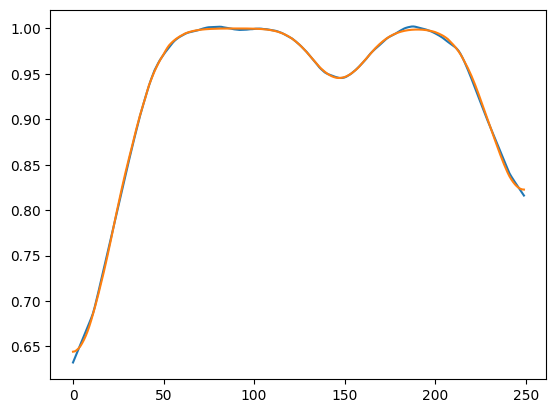

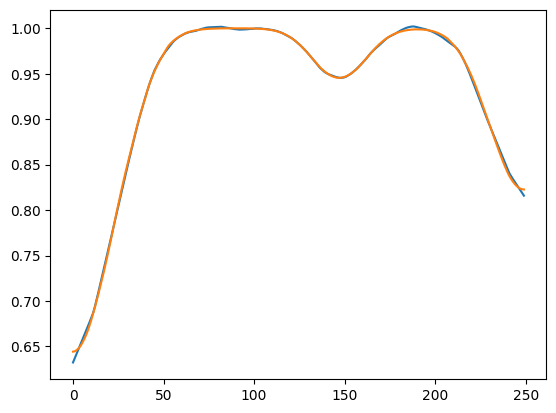

In [288]:


x_axis_torch = torch.from_numpy(wd_scaled).float().to(device)

# For each epoch...
for epoch in range(n_epochs):

    model.train()
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.cpu().detach().numpy())

    if (epoch % plot_every)==0:
      out = model(x_axis_torch).cpu().detach().numpy()
      out2 = farm_power/scaling

      plt.plot(out)
      plt.plot(out2)
      plt.show()